<a href="https://colab.research.google.com/github/ramen-newdals/APS360_project/blob/master/Feature_Extraction_and_Classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Learning 1: dataset not balanced creates problems 
# Learning 2: simply creating duplicates does not work well (https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6)
# Learning 3: data augmentation to create only more negative and not changing positive works well - more training is needed - but val still starts higher AND both, train and val, start @ ~65 and ~75% accuracy which is high 
# Learning 4: AlexNet works because it is finding shapes/features
#             (To understand/ask 1: Why does AlexNet end up working so well even though melanoma data not part of its training? Is it becasue data augmentation was not applied on positive data so its really good at understanding that data (i.e. its still biased but less which will why it has to learn more))
# Learning 5: CNN Classifier could work but ANN is working so it is overkill and no reason to use
#             (To try 3: CNN classifier - this is overkill but doesnt hurt to try for the sake of reporting results/learning)
# Learning 6: After Learning 3 - Trying to balance dataset by only using some positive and all negative and then applying data augmentation to both such that training is done with same number of images works very well 
#             (To try 1: Apply the same data augmentation to positive_data but keep datasets balanced so now will be used less data to train (would have to move any images not being used to compeltly isolated dir -> and rmr that, that dir is ALL positive data))

# To try 4: check balance of data in test set without data augm. and then compare to results (specifically, try different ratios with data augm. and see if model is able to avoid using bias of occurence in data to predit and ALSO if this even is what the model is doing without data augm.)
# (a) If you can prove that original unbalanced, unaugmented dataset is infact not useful as it essentially defaults no non-melanoma then good (this would mean that the model is using training data occurence as a bias and instead of learning features/relations it is just using popularity)
# (b) Then also prove that using data augmentation does work, and show that even with different ratios of testing data (using 90:10, 50:50, 10:90) accuracy is still high -> essentially it is now dataset size independent and is learning from features
#     Etiher use this same idea for (a) or find a way to show that the specific label of negative-melanoma is always predicted incorrectly
#     Would need 2 accuracy functions to see when negative is predicted correctly and when positive is predicted correctly -- this may be easier to implement as itll essentially be very similar to get_accuracy function (essentially equivalent to finding false positive rate and false negative rate (where neg = melanoma)) -- 1-true positive = false positive -- 1 - (how often it correctly guesses non-melanoma) = (how often it incorrectly guesses non-melanoma) (i.e. was negative but model guesses positive) 
#     To ^ first and then try to change ratios to see how model behaves 

# If both of above show that model is not working then develop you own CNN to learn features on its own 
# To try 2: Train my own CNN based on AlexNet or LeNet5 

# To understand/ask 2: What other transfer learning could work well? (Perhaps Google? If AlexNet works well then no point)

# note: imagenet: https://pillow.readthedocs.io/en/stable/reference/Image.html


# **Importing Libraries**

In [ ]:
!pip install split-folders
#!pip install Pillow

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import split_folders

import shutil
import csv
import os
from PIL import Image
from PIL import ImageFilter
from google.colab import output

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Sort Images**

### **Extract Images**

In [ ]:
# Directory to hold raw, unsorted, data
data_directory = '/root/datasets/Data'
if not os.path.isdir(data_directory): os.makedirs(data_directory)

! unzip '/content/gdrive/My Drive/APS360 Project/54339_104884_upload_HAM10000_images_part_1.zip' -d '/root/datasets/Data'

# clear output for easy readability 
output.clear()

### **Divide Images**

In [ ]:
def divide_images(limit_positive_images = 436):

  os.chdir(data_directory)
  entries = os.listdir(data_directory)

#------------------------Making meta data for all the images---------------------#

  image_label = []
  image_classification = []

  with open('/content/gdrive/My Drive/APS360 Project/datasets_54339_104884_HAM10000_metadata.csv') as meta_data:
      csv_reader = csv.reader(meta_data, delimiter=',')
      line_count = 0
      for row in csv_reader:
          image_label.append(row[1])
          image_classification.append(row[2])

  image_meta_data = dict(zip(image_label, image_classification))
  #print(image_meta_data)

#------------Moving the Data into the required folders for training--------------#

  positive_data = '/root/datasets/seperated_data/positive_data'
  negative_data = '/root/datasets/seperated_data/negative_data'
  if not os.path.isdir(positive_data): 
    os.makedirs(positive_data)
  if not os.path.isdir(negative_data): 
    os.makedirs(negative_data)

  pos = 0
  for image in entries:
    if image_meta_data[image[:(len(image)-4)]] == 'mel':
      shutil.copy(data_directory + "/" + image , negative_data + "/" + image)
    else:
      pos+=1
      if pos<436: shutil.copy(data_directory + "/" + image , positive_data + "/" + image)

In [ ]:
divide_images()

# **Data Augmentation**

In [ ]:
def data_augmentation(my_directory):

  data_aug_dir = '/root/datasets/seperated_data/data_aug'
  if not os.path.isdir(data_aug_dir): os.makedirs(data_aug_dir) 
  
  entries = os.listdir(my_directory)

  for count in range(0,2):
    for imagefile in entries:
      
      os.chdir(my_directory)

      im = Image.open(imagefile)
      im=im.convert("RGB")
      r,g,b=im.split()
      r=r.convert("RGB")
      g=g.convert("RGB")
      b=b.convert("RGB")
      im_blur=im.filter(ImageFilter.GaussianBlur)
      im_unsharp=im.filter(ImageFilter.UnsharpMask)

      os.chdir(data_aug_dir)
      
      r.save(str(count)+'r_'+imagefile)
      g.save(str(count)+'g_'+imagefile)
      b.save(str(count)+'b_'+imagefile)
      im_blur.save(str(count)+'bl_'+imagefile)
      im_unsharp.save(str(count)+'un_'+imagefile)
    print('done')

  augmented_images = os.listdir(data_aug_dir)
  for image in augmented_images: shutil.move(os.path.join(data_aug_dir, image), my_directory)
  
  shutil.rmtree(data_aug_dir)

  os.chdir('/root/datasets/Data')

In [ ]:
neg_directory = '/root/datasets/seperated_data/negative_data'
pos_directory = '/root/datasets/seperated_data/positive_data'

data_augmentation(neg_directory)
data_augmentation(pos_directory)

### **Visualise Augmented Data**

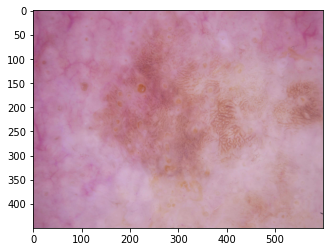

In [ ]:
img = plt.imread('/root/datasets/seperated_data/positive_data/ISIC_0028792.jpg')
plt.imshow(img)

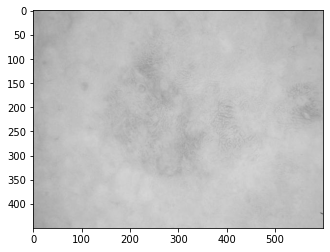

In [ ]:
img = plt.imread('/root/datasets/seperated_data/positive_data/1r_ISIC_0028792.jpg')
plt.imshow(img)

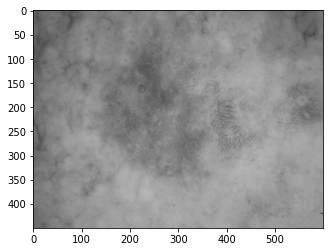

In [ ]:
img = plt.imread('/root/datasets/seperated_data/positive_data/1g_ISIC_0028792.jpg')
plt.imshow(img)

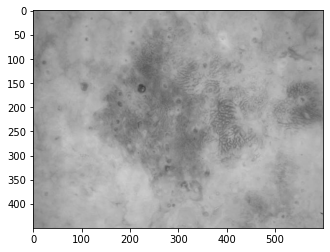

In [ ]:
img = plt.imread('/root/datasets/seperated_data/positive_data/1b_ISIC_0028792.jpg')
plt.imshow(img)

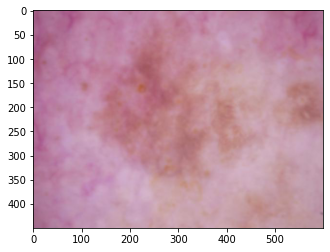

In [ ]:
img = plt.imread('/root/datasets/seperated_data/positive_data/1bl_ISIC_0028792.jpg')
plt.imshow(img)

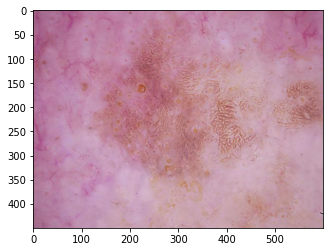

In [ ]:
img = plt.imread('/root/datasets/seperated_data/positive_data/1un_ISIC_0028792.jpg')
plt.imshow(img)

# **Split Data, Get Data Loaders and Save AlexNet Features**

In [ ]:
def get_data_loaders(batch_size, overfitting = True):
  
  transform = transforms.Compose(
      [transforms.CenterCrop(224),
          transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  train_path = '/root/datasets/Data_Split/train'

  #if overfitting: 
  #  train_path = '/content/gdrive/My Drive/Lab3b/Lab_3b_Overfitting_Gesture_Dataset'

  val_path = '/root/datasets/Data_Split/val'
  test_path = '/root/datasets/Data_Split/test'
  
  train_data = torchvision.datasets.ImageFolder(root = train_path, transform=transform)
  val_data = torchvision.datasets.ImageFolder(root = val_path, transform=transform)
  test_data = torchvision.datasets.ImageFolder(root = test_path, transform=transform)
  
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
  
  return train_loader, val_loader, test_loader

def get_AlexNet_features(data_loader, folder):
  n = 0
  features_path = '/content/gdrive/My Drive/APS360 Project/AlexNet_Features_Balanced_Coloured'
  #why save this on drive? - save this on computer --> but then you would have to keep running this
  classes = ['negative_data', 'positive_data']

  for img, label in data_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = features_path + '/' + folder + '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.makedirs(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

  print("Done")

### **Split Data**

In [ ]:
if not os.path.isdir('/root/datasets/Data_Split'):
  os.makedirs('/root/datasets/Data_Split')
  split_folders.ratio("/root/datasets/seperated_data", output='/root/datasets/Data_Split', seed=1337, ratio=(.70, .10, .20)) # default value

Copying files: 9570 files [00:02, 4529.67 files/s]


### **Save AlexNet Features**

In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size, overfitting=False)
  
# save features to folder as tensors
get_AlexNet_features(train_loader, folder="Training")
get_AlexNet_features(val_loader,folder="Validation")
get_AlexNet_features(test_loader,folder="Testing")

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


# **Classifier Network and Training/Validation**

In [ ]:
# Artifical Neural Network Architecture

class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.name = "pigeon"
        self.fc1 = nn.Linear(256*6*6, 72)
        self.fc2 = nn.Linear(72, 2)

    def forward(self, img):
        flattened = img.view(-1, 256*6*6)
        activation1 = self.fc1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.fc2(activation1)

        return activation2

In [ ]:
def get_accuracy(model, feature_loader):

    correct = 0
    total = 0
    
    for i, data in enumerate(feature_loader,0):
      
        features, labels = data
        #To Enable GPU Usage
        
        if use_cuda and torch.cuda.is_available():
          features = features.cuda()
          labels = labels.cuda()
          
        output = model(features)
        #select index with maximum prediction score
        
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += features.shape[0]
        
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train_AlexNetFeatures(model, batch_size=20, learning_rate=0.01, num_epochs=1):
    
    torch.manual_seed(1000) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
      
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for features, labels in iter(training_features_loader):
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            out = model(features)         # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            # Mini_batch Accuracy 
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = features.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
            # Save the current training information
            iters.append(n)
            # compute *average* loss
            losses.append(float(loss)/batch_size) 
            # compute validation accuracy
            
            val_acc.append(get_accuracy(model, val_features_loader))  
            
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(training_features_loader) + mini_b) / (num_epochs * len(training_features_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        print("Training Accuracy: {}".format(train_acc[-1]))
        print("Validation Accuracy: {}".format(val_acc[-1]))

    end_time= time.time()
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, training_features_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

### **Get Features Data Loaders**

In [ ]:
def get_features_data_loaders(folder, batch_size = 512):
  
  features_path = '/content/gdrive/My Drive/APS360 Project/AlexNet_Features_Balanced_Coloured'

  data_path = os.path.join(features_path, folder)
  dataset = torchvision.datasets.DatasetFolder(data_path, loader=torch.load, extensions=('.tensor'))
  features_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                    num_workers=1, shuffle=True)
    
  return features_loader 

# **Training**

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.13  % Time Elapsed:  283.13 s 
Iteration:  2 Progress:   0.26  % Time Elapsed:  284.99 s 
Iteration:  3 Progress:   0.38  % Time Elapsed:  286.83 s 
Iteration:  4 Progress:   0.51  % Time Elapsed:  362.92 s 
Iteration:  5 Progress:   0.64  % Time Elapsed:  435.54 s 
Iteration:  6 Progress:   0.77  % Time Elapsed:  508.73 s 
Iteration:  7 Progress:   0.90  % Time Elapsed:  582.25 s 
Iteration:  8 Progress:   1.03  % Time Elapsed:  655.97 s 
Iteration:  9 Progress:   1.15  % Time Elapsed:  728.58 s 
Iteration:  10 Progress:   1.28  % Time Elapsed:  819.68 s 
Iteration:  11 Progress:   1.41  % Time Elapsed:  891.48 s 
Iteration:  12 Progress:   1.54  % Time Elapsed:  964.84 s 
Iteration:  13 Progress:   1.67  % Time Elapsed:  975.75 s 
Epoch 0 Finished.  Time per Epoch:  975.76 s 
Training Accuracy: 0.39473684210526316
Validation Accuracy: 0.49581589958158995
Iteration:  14 Progress:   1.79  % Time Elapsed:  979.12 s 

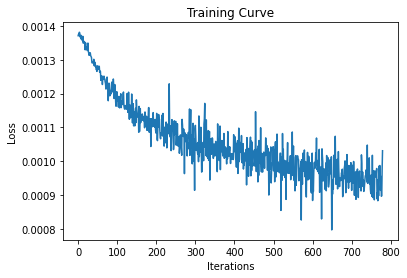

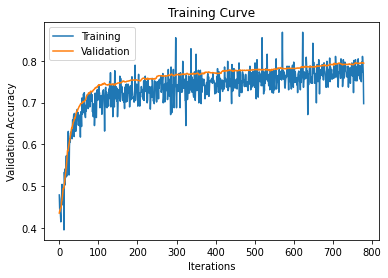

Final Training Accuracy: 0.7766881028938907
Final Validation Accuracy: 0.794281729428173
Total time:   2692.05 s  Time per Epoch:  44.87 s 


In [ ]:
use_cuda = True

batch_size = 512
lr = 0.0001
epochs = 60

training_features_loader = get_features_data_loaders("Training")
val_features_loader = get_features_data_loaders("Validation")

model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = lr, num_epochs=epochs)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.13  % Time Elapsed:   3.37 s 
Iteration:  2 Progress:   0.26  % Time Elapsed:   5.58 s 
Iteration:  3 Progress:   0.38  % Time Elapsed:   7.82 s 
Iteration:  4 Progress:   0.51  % Time Elapsed:  10.04 s 
Iteration:  5 Progress:   0.64  % Time Elapsed:  12.25 s 
Iteration:  6 Progress:   0.77  % Time Elapsed:  14.47 s 
Iteration:  7 Progress:   0.90  % Time Elapsed:  16.69 s 
Iteration:  8 Progress:   1.03  % Time Elapsed:  18.90 s 
Iteration:  9 Progress:   1.15  % Time Elapsed:  21.12 s 
Iteration:  10 Progress:   1.28  % Time Elapsed:  23.33 s 
Iteration:  11 Progress:   1.41  % Time Elapsed:  25.23 s 
Iteration:  12 Progress:   1.54  % Time Elapsed:  27.08 s 
Iteration:  13 Progress:   1.67  % Time Elapsed:  28.90 s 
Epoch 0 Finished.  Time per Epoch:  28.91 s 
Training Accuracy: 0.618421052631579
Validation Accuracy: 0.704323570432357
Iteration:  14 Progress:   1.79  % Time Elapsed:  32.31 s 
Iteration:  15 Pro

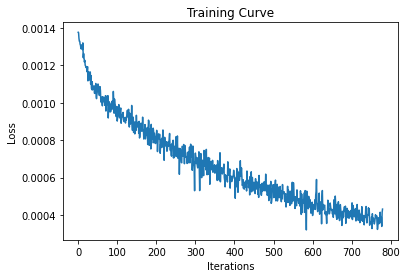

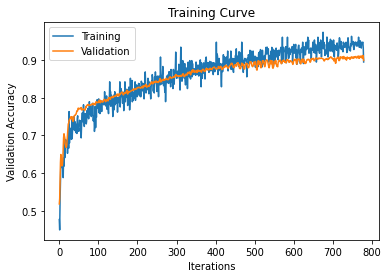

Final Training Accuracy: 0.9369774919614148
Final Validation Accuracy: 0.898884239888424
Total time:   1771.18 s  Time per Epoch:  29.52 s 


In [ ]:
use_cuda = True

batch_size = 512
lr = 0.001
epochs = 60

training_features_loader = get_features_data_loaders("Training")
val_features_loader = get_features_data_loaders("Validation")

model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = lr, num_epochs=epochs)

done
done
CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.04  % Time Elapsed:   2.49 s 
Iteration:  2 Progress:   0.08  % Time Elapsed:   4.39 s 
Iteration:  3 Progress:   0.12  % Time Elapsed:   6.28 s 
Iteration:  4 Progress:   0.16  % Time Elapsed:  36.10 s 
Iteration:  5 Progress:   0.20  % Time Elapsed:  67.92 s 
Iteration:  6 Progress:   0.24  % Time Elapsed:  100.62 s 
Iteration:  7 Progress:   0.29  % Time Elapsed:  141.75 s 
Iteration:  8 Progress:   0.33  % Time Elapsed:  189.09 s 
Iteration:  9 Progress:   0.37  % Time Elapsed:  223.93 s 
Iteration:  10 Progress:   0.41  % Time Elapsed:  259.67 s 
Iteration:  11 Progress:   0.45  % Time Elapsed:  294.31 s 
Iteration:  12 Progress:   0.49  % Time Elapsed:  322.24 s 
Iteration:  13 Progress:   0.53  % Time Elapsed:  349.44 s 
Iteration:  14 Progress:   0.57  % Time Elapsed:  377.94 s 
Iteration:  15 Progress:   0.61  % Time Elapsed:  405.37 s 
Iteration:  16 Progress:   0.65  % Time Elapsed:  432.41 s 


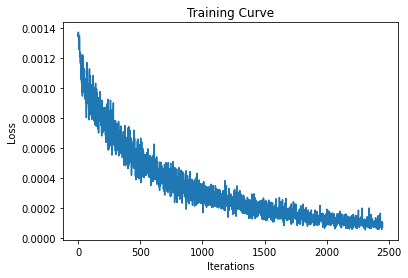

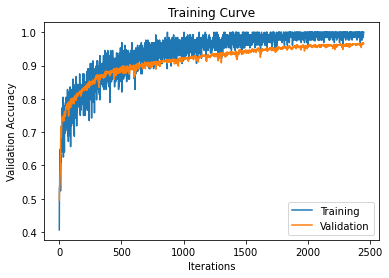

Final Training Accuracy: 0.9956591639871383
Final Validation Accuracy: 0.9651324965132496
Total time:   6159.79 s  Time per Epoch:  123.20 s 


In [ ]:
use_cuda = True

batch_size = 512
training_features_loader = get_features_data_loaders("Training")
val_features_loader = get_features_data_loaders("Validation")

model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = 0.001, num_epochs=50)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.13  % Time Elapsed:   3.53 s 
Iteration:  2 Progress:   0.26  % Time Elapsed:   5.82 s 
Iteration:  3 Progress:   0.38  % Time Elapsed:   8.10 s 
Iteration:  4 Progress:   0.51  % Time Elapsed:  10.35 s 
Iteration:  5 Progress:   0.64  % Time Elapsed:  12.61 s 
Iteration:  6 Progress:   0.77  % Time Elapsed:  14.88 s 
Iteration:  7 Progress:   0.90  % Time Elapsed:  17.14 s 
Iteration:  8 Progress:   1.03  % Time Elapsed:  19.37 s 
Iteration:  9 Progress:   1.15  % Time Elapsed:  21.61 s 
Iteration:  10 Progress:   1.28  % Time Elapsed:  23.89 s 
Iteration:  11 Progress:   1.41  % Time Elapsed:  25.81 s 
Iteration:  12 Progress:   1.54  % Time Elapsed:  27.67 s 
Iteration:  13 Progress:   1.67  % Time Elapsed:  29.50 s 
Epoch 0 Finished.  Time per Epoch:  29.51 s 
Training Accuracy: 0.6842105263157895
Validation Accuracy: 0.7322175732217573
Iteration:  14 Progress:   1.79  % Time Elapsed:  32.89 s 
Iteration:  15 P

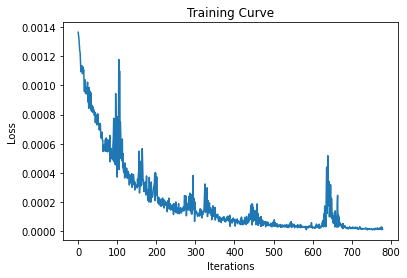

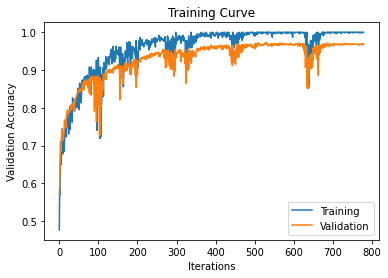

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9693165969316597
Total time:   1775.81 s  Time per Epoch:  29.60 s 


In [ ]:
use_cuda = True

batch_size = 512
lr = 0.01
epochs = 60

training_features_loader = get_features_data_loaders("Training")
val_features_loader = get_features_data_loaders("Validation")

model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = lr, num_epochs=epochs)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.13  % Time Elapsed:   3.42 s 
Iteration:  2 Progress:   0.26  % Time Elapsed:   5.65 s 
Iteration:  3 Progress:   0.38  % Time Elapsed:   7.88 s 
Iteration:  4 Progress:   0.51  % Time Elapsed:  10.16 s 
Iteration:  5 Progress:   0.64  % Time Elapsed:  12.42 s 
Iteration:  6 Progress:   0.77  % Time Elapsed:  14.68 s 
Iteration:  7 Progress:   0.90  % Time Elapsed:  16.94 s 
Iteration:  8 Progress:   1.03  % Time Elapsed:  19.20 s 
Iteration:  9 Progress:   1.15  % Time Elapsed:  21.85 s 
Iteration:  10 Progress:   1.28  % Time Elapsed:  24.54 s 
Iteration:  11 Progress:   1.41  % Time Elapsed:  26.92 s 
Iteration:  12 Progress:   1.54  % Time Elapsed:  29.25 s 
Iteration:  13 Progress:   1.67  % Time Elapsed:  31.22 s 
Epoch 0 Finished.  Time per Epoch:  31.23 s 
Training Accuracy: 0.6973684210526315
Validation Accuracy: 0.699442119944212
Iteration:  14 Progress:   1.79  % Time Elapsed:  34.89 s 
Iteration:  15 Pr

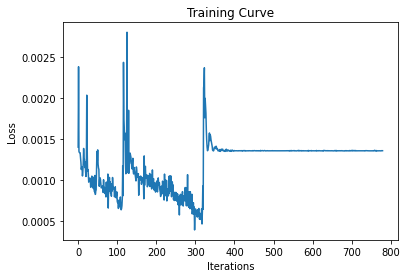

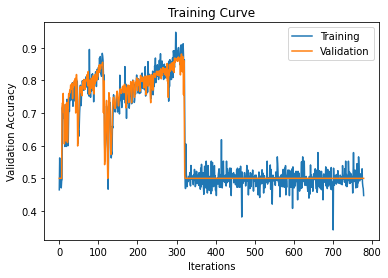

Final Training Accuracy: 0.5
Final Validation Accuracy: 0.5
Total time:   1780.20 s  Time per Epoch:  29.67 s 


In [ ]:
use_cuda = True

batch_size = 512
lr = 0.1
epochs = 60

training_features_loader = get_features_data_loaders("Training")
val_features_loader = get_features_data_loaders("Validation")

model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = lr, num_epochs=epochs)

### **Other Models/Attempts**

In [ ]:
######### Learning #########

#bs = 512 -> ok 
#bs = 1024, lr = 0.0001, e = 3 -> noisy but ok 
#bs = 1024, lr = 0.001, e = 20 (based on Lab3b learning) -> good

# just try more epochs - maybe thats good enough? 
# try lower (0.0001) and higher (0.01) -> RESULT? -> apply one ore magnitude of whichever is better 
# try CNN

#train_AlexNetFeatures(model, batch_size=large, learning_rate = 0.1, num_epochs=20)

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.00  % Time Elapsed:   5.73 s 
Iteration:  2 Progress:   0.00  % Time Elapsed:   9.46 s 
Iteration:  3 Progress:   0.00  % Time Elapsed:  12.82 s 
Iteration:  4 Progress:   0.00  % Time Elapsed:  16.16 s 
Iteration:  5 Progress:   0.00  % Time Elapsed:  18.62 s 
Iteration:  6 Progress:   0.00  % Time Elapsed:  21.00 s 
Iteration:  7 Progress:   0.01  % Time Elapsed:  23.37 s 
Epoch 0 Finished.  Time per Epoch:  23.41 s 
Iteration:  8 Progress:   5.00  % Time Elapsed:  29.05 s 
Iteration:  9 Progress:   5.00  % Time Elapsed:  32.86 s 
Iteration:  10 Progress:   5.00  % Time Elapsed:  36.26 s 
Iteration:  11 Progress:   5.00  % Time Elapsed:  39.54 s 
Iteration:  12 Progress:   5.00  % Time Elapsed:  42.02 s 
Iteration:  13 Progress:   5.00  % Time Elapsed:  44.39 s 
Iteration:  14 Progress:   5.01  % Time Elapsed:  46.78 s 
Epoch 1 Finished.  Time per Epoch:  23.41 s 
Iteration:  15 Progress:  10.00  % Time Elapsed:  52.

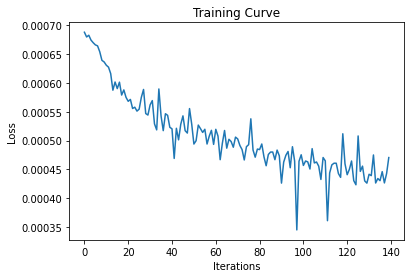

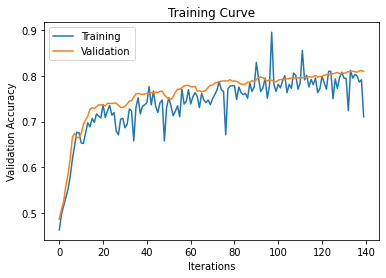

Final Training Accuracy: 0.7959807073954984
Final Validation Accuracy: 0.8096234309623431
Total time:   468.07 s  Time per Epoch:  23.40 s 


In [ ]:
use_cuda = True
model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = 0.001, num_epochs=20)

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.01  % Time Elapsed:   4.47 s 
Iteration:  2 Progress:   0.01  % Time Elapsed:   7.93 s 
Iteration:  3 Progress:   0.02  % Time Elapsed:  11.38 s 
Iteration:  4 Progress:   0.02  % Time Elapsed:  14.53 s 
Iteration:  5 Progress:   0.03  % Time Elapsed:  17.36 s 
Iteration:  6 Progress:   0.03  % Time Elapsed:  20.17 s 
Iteration:  7 Progress:   0.04  % Time Elapsed:  22.97 s 
Iteration:  8 Progress:   0.04  % Time Elapsed:  25.78 s 
Iteration:  9 Progress:   0.05  % Time Elapsed:  28.61 s 
Iteration:  10 Progress:   0.05  % Time Elapsed:  31.43 s 
Iteration:  11 Progress:   0.06  % Time Elapsed:  33.84 s 
Iteration:  12 Progress:   0.06  % Time Elapsed:  36.17 s 
Iteration:  13 Progress:   0.07  % Time Elapsed:  38.53 s 
Epoch 0 Finished.  Time per Epoch:  38.57 s 
Iteration:  14 Progress:  33.34  % Time Elapsed:  42.77 s 
Iteration:  15 Progress:  33.34  % Time Elapsed:  45.55 s 
Iteration:  16 Progress:  33.35  % Time

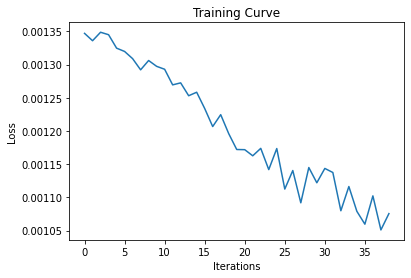

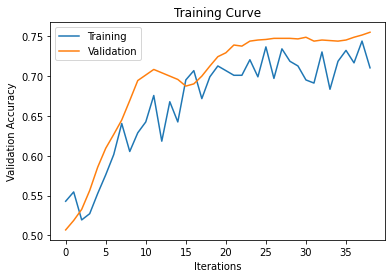

Final Training Accuracy: 0.7223472668810289
Final Validation Accuracy: 0.7552301255230126
Total time:   111.94 s  Time per Epoch:  37.31 s 


In [ ]:
use_cuda = True
model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = 0.001, num_epochs=3)


CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.01  % Time Elapsed:   3.46 s 
Iteration:  2 Progress:   0.01  % Time Elapsed:   6.06 s 
Iteration:  3 Progress:   0.02  % Time Elapsed:   8.73 s 
Iteration:  4 Progress:   0.02  % Time Elapsed:  11.33 s 
Iteration:  5 Progress:   0.03  % Time Elapsed:  13.98 s 
Iteration:  6 Progress:   0.03  % Time Elapsed:  16.61 s 
Iteration:  7 Progress:   0.04  % Time Elapsed:  19.31 s 
Iteration:  8 Progress:   0.04  % Time Elapsed:  21.99 s 
Iteration:  9 Progress:   0.05  % Time Elapsed:  24.62 s 
Iteration:  10 Progress:   0.05  % Time Elapsed:  27.28 s 
Iteration:  11 Progress:   0.06  % Time Elapsed:  29.97 s 
Iteration:  12 Progress:   0.06  % Time Elapsed:  32.56 s 
Iteration:  13 Progress:   0.07  % Time Elapsed:  35.25 s 
Iteration:  14 Progress:   0.08  % Time Elapsed:  37.89 s 
Iteration:  15 Progress:   0.08  % Time Elapsed:  40.53 s 
Iteration:  16 Progress:   0.09  % Time Elapsed:  43.14 s 
Iteration:  17 Progress: 

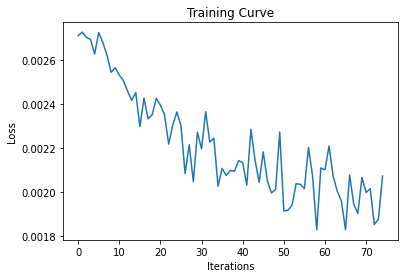

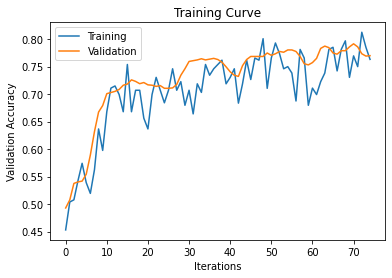

Final Training Accuracy: 0.752572347266881
Final Validation Accuracy: 0.7698744769874477
Total time:   197.06 s  Time per Epoch:  65.69 s 


In [ ]:
use_cuda = True
model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = 0.001, num_epochs=3)


CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.01  % Time Elapsed:   2.98 s 
Iteration:  2 Progress:   0.01  % Time Elapsed:   5.46 s 
Iteration:  3 Progress:   0.02  % Time Elapsed:   7.97 s 
Iteration:  4 Progress:   0.02  % Time Elapsed:  10.48 s 
Iteration:  5 Progress:   0.03  % Time Elapsed:  12.93 s 
Iteration:  6 Progress:   0.03  % Time Elapsed:  15.40 s 
Iteration:  7 Progress:   0.04  % Time Elapsed:  17.87 s 
Iteration:  8 Progress:   0.04  % Time Elapsed:  20.32 s 
Iteration:  9 Progress:   0.05  % Time Elapsed:  22.79 s 
Iteration:  10 Progress:   0.05  % Time Elapsed:  25.24 s 
Iteration:  11 Progress:   0.06  % Time Elapsed:  27.65 s 
Iteration:  12 Progress:   0.06  % Time Elapsed:  30.10 s 
Iteration:  13 Progress:   0.07  % Time Elapsed:  32.58 s 
Iteration:  14 Progress:   0.08  % Time Elapsed:  35.05 s 
Iteration:  15 Progress:   0.08  % Time Elapsed:  37.48 s 
Iteration:  16 Progress:   0.09  % Time Elapsed:  39.93 s 
Iteration:  17 Progress: 

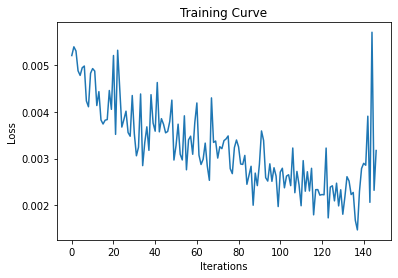

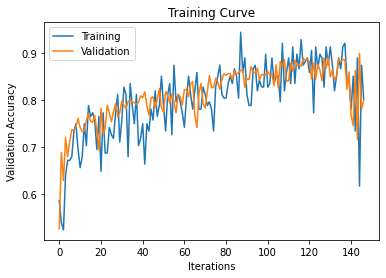

Final Training Accuracy: 0.8036977491961415
Final Validation Accuracy: 0.800557880055788
Total time:   367.24 s  Time per Epoch:  122.41 s 


In [ ]:
use_cuda = True
model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = 0.1, num_epochs=3)


### **Original Training**

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.02  % Time Elapsed:  1361.03 s 
Iteration:  2 Progress:   0.03  % Time Elapsed:  1363.19 s 
Iteration:  3 Progress:   0.05  % Time Elapsed:  1365.24 s 
Iteration:  4 Progress:   0.06  % Time Elapsed:  1456.27 s 
Iteration:  5 Progress:   0.08  % Time Elapsed:  1548.64 s 
Iteration:  6 Progress:   0.09  % Time Elapsed:  1646.22 s 
Iteration:  7 Progress:   0.11  % Time Elapsed:  1735.23 s 
Iteration:  8 Progress:   0.12  % Time Elapsed:  1824.97 s 
Iteration:  9 Progress:   0.14  % Time Elapsed:  1914.18 s 
Iteration:  10 Progress:   0.15  % Time Elapsed:  2008.34 s 
Iteration:  11 Progress:   0.17  % Time Elapsed:  2098.95 s 
Iteration:  12 Progress:   0.18  % Time Elapsed:  2190.95 s 
Iteration:  13 Progress:   0.20  % Time Elapsed:  2281.42 s 
Iteration:  14 Progress:   0.22  % Time Elapsed:  2372.45 s 
Iteration:  15 Progress:   0.23  % Time Elapsed:  2462.65 s 
Iteration:  16 Progress:   0.25  % Time Elapsed:  2552

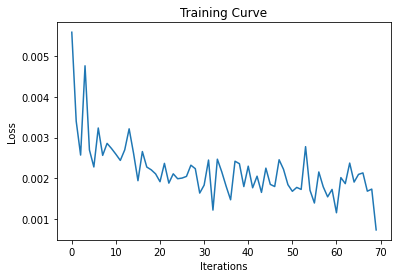

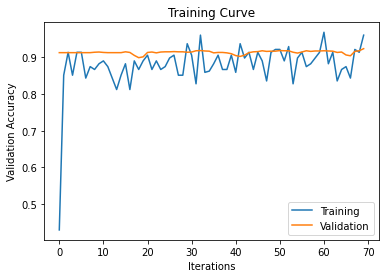

Final Training Accuracy: 0.895525777878719
Final Validation Accuracy: 0.923956546598056
Total time:   4279.93 s  Time per Epoch:  2139.96 s 


In [ ]:
############################## O ###############################################
use_cuda = True
model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_AlexNetFeatures(model, batch_size=batch_size, learning_rate = 0.01, num_epochs=2)
#1: CNN: bs = 256, lr = 0.1 -> training = 91%

# **Testing**

### **False Positive and False Negative Error Rate**

In [ ]:
def get_accuracy_test(model, feature_loader):

    correct = 0
    total = 0
    
    pos_correct = 0
    pos_total = 0

    neg_correct = 0
    neg_total = 0

    for i, data in enumerate(feature_loader,0):
      
        features, labels = data
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          features = features.cuda()
          labels = labels.cuda()
        
        #print(labels[0])
        #print(len(features))
        output = model(features)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        #print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += features.shape[0]

        for i, l in enumerate(labels):
          label = l
          #print(label)
          #print(pred[i])
          if label == 0: neg_total+=1
          else: pos_total+=1
          #print(pos_total)
          #print(neg_total)
          if label == 0 and pred[i] == 0: neg_correct+=1
          if label == 1 and pred[i] == 1: pos_correct+=1
          #print(pos_correct)
          #print(neg_correct)
          #print("####")
          #if i == 10: break
    return correct / total, (neg_total - neg_correct)/neg_total, (pos_total - pos_correct)/pos_total

#0 = melanoma (neg)
#1 = non-melanoma (pos)

In [ ]:
model = ANNClassifier()
model_path = get_model_name(model.name, batch_size=512, learning_rate=0.0001, epoch=59)
state = torch.load(model_path)
model.load_state_dict(state)

test_features_loader = get_features_data_loaders("Testing") #could set to Testing/New if setting different ratios 
test_acc, false_pos, false_neg = get_accuracy_test(model, test_features_loader)

print(f"Test Classification Accuracy = {test_acc}")
print(f"Test False Positive Rate = {false_pos}")
print(f"Test False Negative Rate = {false_neg}")


Test Classification Accuracy = 0.7661795407098121
Test False Positive Rate = 0.20981210855949894
Test False Negative Rate = 0.2578288100208768


In [ ]:
model = ANNClassifier()
model_path = get_model_name(model.name, batch_size=512, learning_rate=0.001, epoch=59)
state = torch.load(model_path)
model.load_state_dict(state)

test_features_loader = get_features_data_loaders("Testing") #could set to Testing/New if setting different ratios 
test_acc, false_pos, false_neg = get_accuracy_test(model, test_features_loader)

print(f"Test Classification Accuracy = {test_acc}")
print(f"Test False Positive Rate = {false_pos}")
print(f"Test False Negative Rate = {false_neg}")


Test Classification Accuracy = 0.9024008350730689
Test False Positive Rate = 0.05741127348643006
Test False Negative Rate = 0.13778705636743216


In [ ]:
model = ANNClassifier()
model_path = get_model_name(model.name, batch_size=512, learning_rate=0.01, epoch=59)
state = torch.load(model_path)
model.load_state_dict(state)

test_features_loader = get_features_data_loaders("Testing") #could set to Testing/New if setting different ratios 
test_acc, false_pos, false_neg = get_accuracy_test(model, test_features_loader)

print(f"Test Classification Accuracy = {test_acc}")
print(f"Test False Positive Rate = {false_pos}")
print(f"Test False Negative Rate = {false_neg}")


Test Classification Accuracy = 0.9692066805845512
Test False Positive Rate = 0.029227557411273485
Test False Negative Rate = 0.032359081419624215


In [ ]:
model = ANNClassifier()
model_path = get_model_name(model.name, batch_size=512, learning_rate=0.1, epoch=59)
state = torch.load(model_path)
model.load_state_dict(state)

test_features_loader = get_features_data_loaders("Testing") #could set to Testing/New if setting different ratios 
test_acc, false_pos, false_neg = get_accuracy_test(model, test_features_loader)

print(f"Test Classification Accuracy = {test_acc}")
print(f"Test False Positive Rate = {false_pos}")
print(f"Test False Negative Rate = {false_neg}")


Test Classification Accuracy = 0.5
Test False Positive Rate = 0.0
Test False Negative Rate = 1.0
